# Titanic

## Imports

In [5]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import seaborn as sns
from IPython.core.display import display, HTML
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

def reset_random_seeds():
    tf.random.set_seed(0)
    np.random.seed(0)
    random.seed(0)
reset_random_seeds()

ModuleNotFoundError: No module named 'keras'

## Notebook formatting

In [2]:
# Forcing jupyter to display in full-width
display(HTML("<style>.container { width:100% !important; }</style>"))

## Loading data and feature engineering

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
# Create a function that takes names and returns titles
def name_sep(data):
    families=[]
    titles = []
    new_name = []
    #for each row in dataset:
    for i in range(len(data)):
        name = data.iloc[i]
        # extract name inside brakets into name_bracket:
        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name  
        family = name_no_bracket.split(",")[0]
        title = name_no_bracket.split(",")[1].strip().split(" ")[0]
        # remove punctuations except brackets:
        for c in string.punctuation:
            name = name.replace(c,"").strip()
            family = family.replace(c,"").strip()
            title = title.replace(c,"").strip()
        families.append(family)
        titles.append(title)
        new_name.append(name)
    return families, titles, new_name   

# create a function that takes ticket feature and returns list of ticket_types
def ticket_sep(data_ticket):
    ticket_type = []
    for i in range(len(data_ticket)):
            ticket =data_ticket.iloc[i]
            for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
            if len(splited_ticket) == 1:
                ticket_type.append('#')
            else: 
                ticket_type.append(splited_ticket[0])
    return ticket_type 

#create a function that takes cabin from dataset and extracts cabin type for each cabin that is not missing.
# If cabin is missing, leaves missing value:
def cabin_sep(data_cabin):
    cabin_type = []
    for i in range(len(data_cabin)):
            if data_cabin.isnull()[i] == True: 
                cabin_type.append('NaN') 
            else:    
                cabin = data_cabin[i]
                cabin_type.append(cabin[:1]) 
    return cabin_type

In [5]:
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Fare"] = test["Fare"].fillna(test["Fare"].median())
train["Embarked"] = train["Embarked"].fillna(train.Embarked.mode()[0])
test["Embarked"] = test["Embarked"].fillna(test.Embarked.mode()[0])
train = train.drop(["PassengerId"], axis=1) # doesn't serve any purpose
# test = test.drop(["PassengerId"], axis=1)

# Title of person should have a significant say in whether the person survived
train['Family'], train['Title'], train['Name']  = name_sep(train.Name)
test['Family'], test['Title'], test['Name']  = name_sep(test.Name)
# for those types that have less than 15 samples in training set, assign type to 'other':
for t in train['Title'].unique():
    if len(train[train['Title']==t]) <= 15:
        train.loc[train.Title ==t, 'Title'] = 'other'
for t in test['Title'].unique():
    if t not in train['Title'].unique():
        test.loc[test.Title ==t, 'Title'] = 'other'

# checking overlapping family names in train and test
# families usually stay together if aboard a lifeboat
overlap = [x for x in train.Family.unique() if x in test.Family.unique()]
train['FamilySize'] = train.SibSp + train.Parch +1
test['FamilySize'] = test.SibSp + test.Parch +1
train = train.drop(['Name', 'Family'], axis=1)
test = test.drop(['Name', 'Family'], axis=1)

# ticket type indicates the wealth of a person, which might correlate with their chance to board a lifeboat
train["TicketType"] = ticket_sep(train.Ticket)
test["TicketType"] = ticket_sep(test.Ticket)
for t in train['TicketType'].unique():
    if len(train[train['TicketType'] == t]) < 15:
        train.loc[train.TicketType == t, 'TicketType'] = 'other'
for t in test['TicketType'].unique():
    if t not in train['TicketType'].unique():
        test.loc[test.TicketType == t, 'TicketType'] = 'other'
# where ticket_type is 'SOTONOQ' convert it to 'A5'
train["TicketType"] = np.where(train["TicketType"]=='SOTONOQ', 'A5', train["TicketType"])
test["TicketType"] = np.where(test["TicketType"]=='SOTONOQ', 'A5', test["TicketType"])
train = train.drop(["Ticket"], axis=1)
test = test.drop(["Ticket"], axis=1)

# cabin type indicates the wealth of a person, which might correlate with their chance to board a lifeboat
train['CabinType'] = cabin_sep(train.Cabin)
test['CabinType'] = cabin_sep(test.Cabin)
# for those types that have less than 15 samples in training set, assign type to 'other':
for t in train['CabinType'].unique():
    if len(train[train['CabinType']==t]) <= 15:
        train.loc[train.CabinType ==t, 'CabinType'] = 'other'
for t in test['CabinType'].unique():
    if t not in train['CabinType'].unique():
        test.loc[test.CabinType ==t, 'CabinType'] = 'other'
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)


# encode categorical to numeric
le = LabelEncoder()
train_LE = train.copy()
test_LE = test.copy()
columns = ['Sex', 'Embarked', 'TicketType', 'CabinType', 'Title']
for col in columns:
    le.fit(train_LE[col])
    train_LE[col] = le.fit_transform(train_LE[col])
    test_LE[col] = le.transform(test_LE[col])

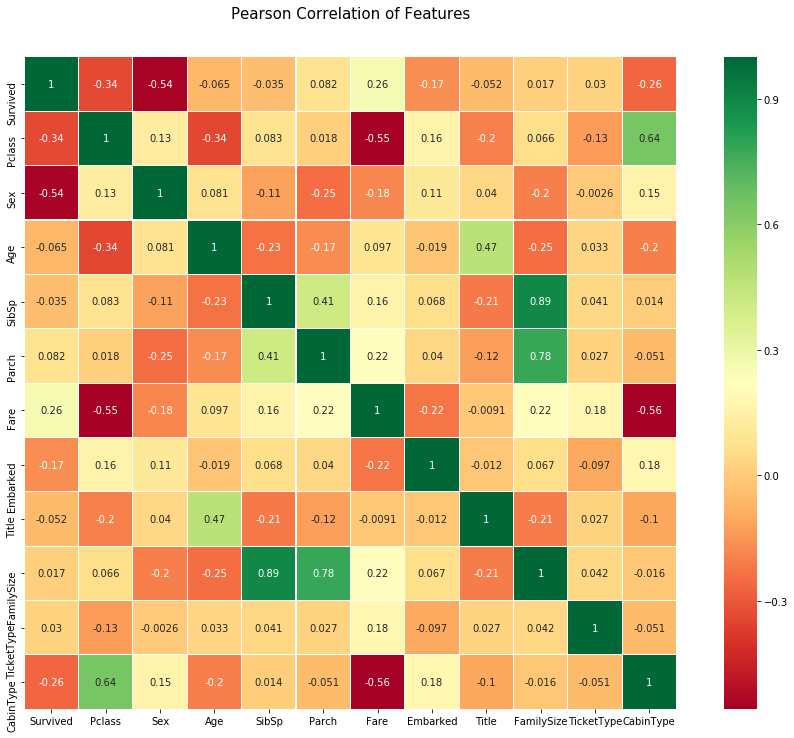

In [6]:
plt.figure(figsize=(17,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_LE.corr(),linewidths=0.1,vmax=1.0, 
            square=True,linecolor='white',cmap='RdYlGn', annot=True)

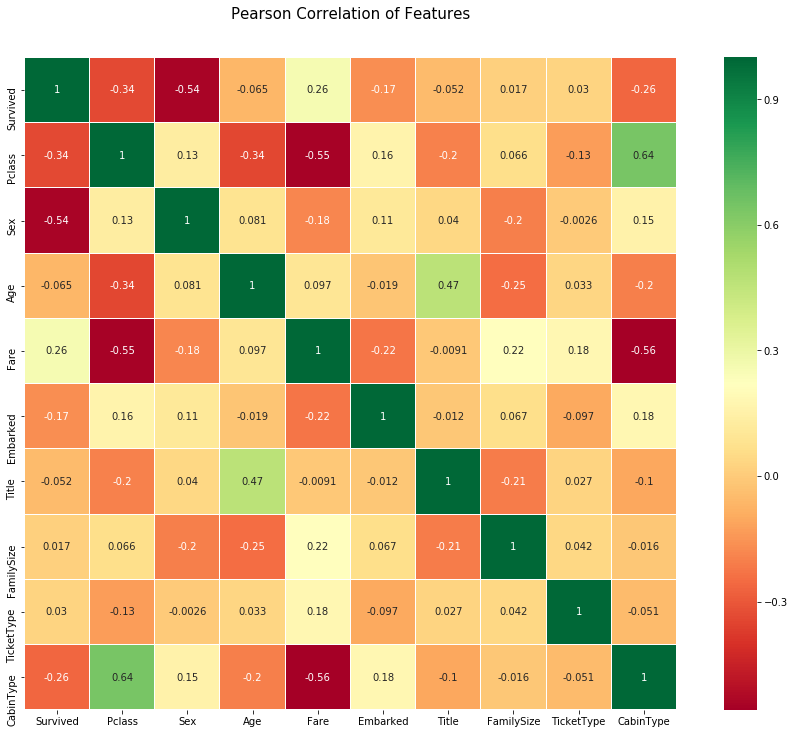

In [7]:
# Dropping the features that highly correlate to FamilySize to reduce overfitting
train_LE = train_LE.drop(['SibSp', 'Parch'], axis=1)
test_LE = test_LE.drop(['SibSp', 'Parch'], axis=1)
plt.figure(figsize=(17,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_LE.corr(),linewidths=0.1,vmax=1.0, 
            square=True,linecolor='white',cmap='RdYlGn', annot=True)

## Visualizations of data

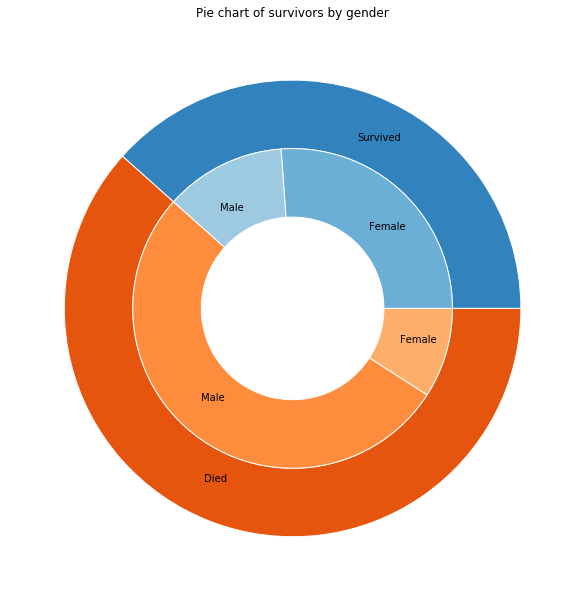

In [315]:
all_males = train_LE.loc[train_LE.Sex == 1].shape[0]
all_females = train_LE.loc[train_LE.Sex == 0].shape[0]
male_survivors = train_LE.loc[train_LE.Sex == 1].Survived.sum()
female_survivors = train_LE.loc[train_LE.Sex == 0].Survived.sum()
group1_labels = ["Survived","Died"]
group2_labels = ["Female","Male","Male","Female"]
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
size = 0.3
vals = np.array([[female_survivors,male_survivors],[all_males-male_survivors,all_females-female_survivors]])
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6]))
ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=group1_labels,labeldistance=0.8)
ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=group2_labels,labeldistance=0.7)
ax.set(aspect="equal", title='Pie chart of survivors by gender')
plt.show()

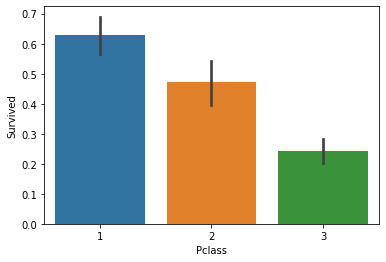

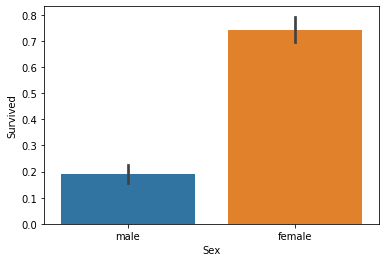

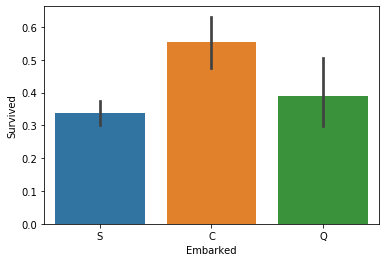

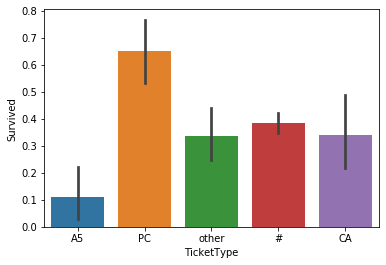

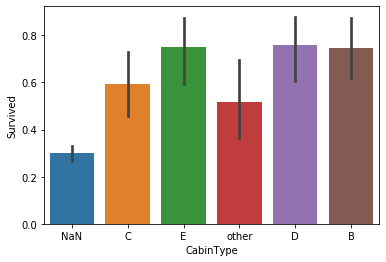

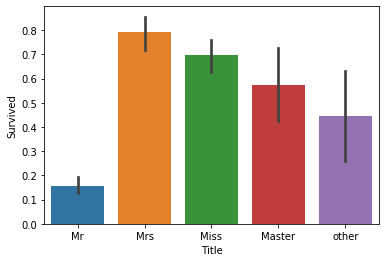

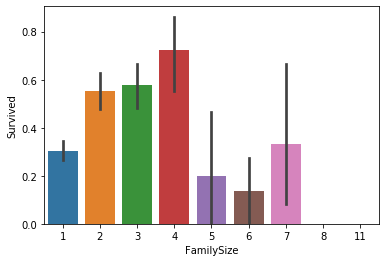

In [316]:
for col in ['Pclass', 'Sex', 'Embarked', 'TicketType', 'CabinType', 'Title',
       'FamilySize']:
    if col in ['Sex', 'Embarked', 'TicketType', 'CabinType', 'Title']:
        sns.barplot(x = col, y = 'Survived', data = train)
    else:
        sns.barplot(x = col, y = 'Survived', data = train_LE)
    plt.show()

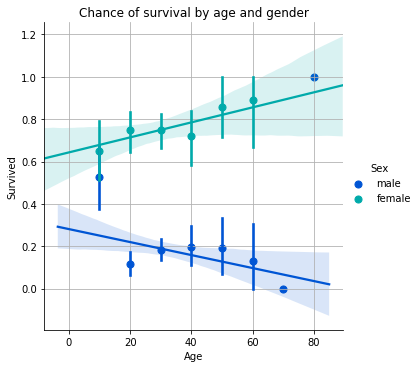

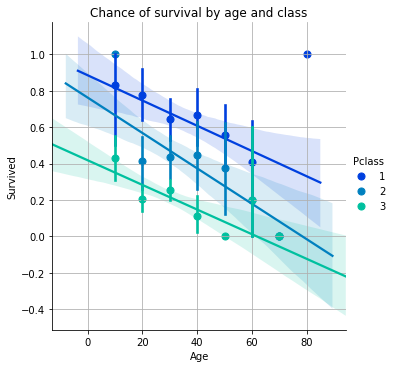

In [317]:
sns.lmplot('Age', 'Survived', hue='Sex', data=train, palette='winter', x_bins=range(10,81,10))
plt.title("Chance of survival by age and gender")
plt.grid()

sns.lmplot('Age', 'Survived', hue='Pclass', data=train, palette='winter', x_bins=range(10,81,10))
plt.title("Chance of survival by age and class")
plt.grid()

In [318]:
print("Highest ticket values:")
display(train.assign(TicketPrice = train['Fare'] / train['FamilySize']).sort_values(["TicketPrice"], ascending=False).
       head(10).drop(["SibSp", "Parch", "Sex",
                       "Title", "FamilySize", "Age", "Embarked", "Survived"], axis=1).
        style.hide_index())

print("Cheapest non-free ticket values:")
display(train.assign(TicketPrice = train['Fare'] / train['FamilySize']).loc[train.Fare != 0]
        .sort_values(["TicketPrice"], ascending=True).
       head(10).drop(["SibSp", "Parch", "Sex",
                       "Title", "Age", "Embarked", "Survived"], axis=1).
        style.hide_index())

Highest ticket values:


Pclass,Fare,TicketType,CabinType,TicketPrice
1,512.329,PC,B,512.329
1,512.329,PC,NaN,512.329
1,512.329,PC,B,256.165
1,227.525,PC,NaN,227.525
1,227.525,PC,C,227.525
1,227.525,PC,NaN,227.525
1,221.779,PC,C,221.779
1,211.338,#,B,211.338
1,153.463,PC,C,153.463
1,151.55,#,NaN,151.55


Cheapest non-free ticket values:


Pclass,Fare,FamilySize,TicketType,CabinType,TicketPrice
3,7.925,7,#,NaN,1.13214
3,7.2292,3,#,NaN,2.40973
3,7.2292,3,#,NaN,2.40973
3,7.75,3,#,NaN,2.58333
3,7.8542,3,#,NaN,2.61807
3,7.925,3,#,NaN,2.64167
3,7.925,3,#,NaN,2.64167
2,11.5,4,#,NaN,2.875
3,8.6625,3,#,NaN,2.8875
2,18.75,6,#,NaN,3.125


### t-SNE plotting of our dataset

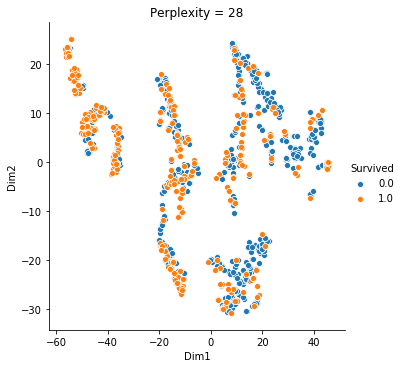

In [319]:
# We can see that there are some clusters which are of very high "purity" - either survivors, or non-survivors.
# From this we can conclude that our dataset can use it's features to classify the survivors with some accuracy.

def plot_TSNE(data,p):
    tsne = TSNE(n_components=2,random_state=0,perplexity=p)
    embeddings = tsne.fit_transform(data)
    return embeddings
# p=190, 21
for p in [28]:
    embeddings = plot_TSNE(train_LE,p)
    plot_data = np.hstack((embeddings,np.array(train_LE.Survived).reshape(len(train_LE.Survived),1)))
    plot_df = pd.DataFrame(plot_data,columns=['Dim1','Dim2','Survived'])
    sns.FacetGrid(plot_df,hue="Survived",height=5).map(sns.scatterplot,"Dim1","Dim2").add_legend()
    plt.title("Perplexity = "+str(p))

### PCA plotting of our dataset

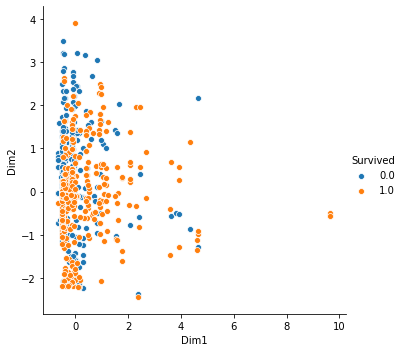

In [320]:
def plot_PCA(data):
    pca = PCA(n_components=2,random_state=0, whiten=True)
    embeddings = pca.fit_transform(data)
    return embeddings
pca = plot_PCA(train_LE)
plot_data = np.hstack((pca,np.array(train_LE.Survived).reshape(len(train_LE.Survived),1)))
plot_df = pd.DataFrame(plot_data,columns=['Dim1','Dim2','Survived'])
sns.FacetGrid(plot_df,hue="Survived",height=5).map(sns.scatterplot,"Dim1","Dim2").add_legend()

## Using PCA with Logistic Regression to classify the survivors

In [8]:
new_train, validation = train_LE.loc[:622,:], train_LE.loc[623:,:] # 70-30 split

best_score, best_n = 0, 1
for n in range(1,new_train.drop(["Survived"], axis=1).shape[1]):
    pca = PCA(n_components=n)
    lr = LogisticRegression(C=1.0, random_state=0, solver='lbfgs', max_iter=5000)
    train_pca = pca.fit_transform(new_train.drop(["Survived"], axis=1))
    validation_results = pca.transform(validation.drop(["Survived"], axis=1))
    lr.fit(train_pca, new_train.Survived)
    predicted = lr.predict(validation_results)
    actual = validation['Survived'].to_numpy()
    pca_score = accuracy_score(predicted, actual)
    if pca_score > best_score:
        best_score = pca_score
        best_n = n
print("Best PCA n_components:\t"+str(best_n))
print("PCA with linear regression score:\t" + str(best_score))

# Creating file for Kaggle:
new_test = test_LE.drop(["PassengerId"], axis=1)
pca = PCA(n_components=best_n)
lr = LogisticRegression(C=1.0, random_state=0, solver='lbfgs', max_iter=5000)
train_pca = pca.fit_transform(train_LE.drop(["Survived"], axis=1))
test_results = pca.transform(new_test)
lr.fit(train_pca, train_LE.Survived)
predicted = lr.predict(test_results)

results = test.loc[:,['PassengerId']]
results["Survived"] = predicted
results.to_csv('results_pca.csv', index=False)

# Kaggle score: 0.66985

Best PCA n_components:	5
PCA with linear regression score:	0.7574626865671642


## Classification of survivors with Decision Tree

In [322]:
parameters = {'min_samples_split': range(2, 7, 1),
              'max_depth': range(3, 10, 1),
              'max_features': ['sqrt',5,6,7,8,9,None]}
gridsearch = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=0), param_grid=parameters,
                   cv=5,iid=False,n_jobs=-1)
clf = gridsearch.fit(new_train.drop(["Survived"], axis=1), new_train.Survived)
predicted = clf.predict(validation.drop(["Survived"], axis=1))
actual = validation['Survived'].to_numpy()
display(gridsearch.best_params_)
print("Decision Tree Classifier score:\t"+str(accuracy_score(predicted,actual)))

# Creating file for Kaggle:
new_test = test_LE.drop(["PassengerId"], axis=1)
predicted = clf.predict(new_test)

results = test.loc[:,['PassengerId']]
results["Survived"] = predicted
results.to_csv('results_dtc.csv', index=False)

# Kaggle score: 0.74162

{'max_depth': 6, 'max_features': 6, 'min_samples_split': 2}

Decision Tree Classifier score:	0.8097014925373134


## Classification of survivors with Random Forest

In [323]:
parameters = {'n_estimators': range(10, 16, 1),
              'min_samples_split': range(2, 6, 1),
              'max_depth': range(4,12,1),
              'max_features': ['sqrt',3,4,5,6,7,None]}
gridsearch = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=0), param_grid=parameters,
                   cv=5,iid=False,n_jobs=-1)
clf = gridsearch.fit(new_train.drop(["Survived"], axis=1), new_train.Survived)
predicted = clf.predict(validation.drop(["Survived"], axis=1))
actual = validation['Survived'].to_numpy()
display(gridsearch.best_params_)
print("Random Forest Classifier score:\t"+str(accuracy_score(predicted,actual)))

# Creating file for Kaggle:
new_test = test_LE.drop(["PassengerId"], axis=1)
predicted = clf.predict(new_test)

results = test.loc[:,['PassengerId']]
results["Survived"] = predicted
results.to_csv('results_rfc.csv', index=False)

# Kaggle score: 0.76555

{'max_depth': 9, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 14}

Random Forest Classifier score:	0.835820895522388


## Classification of survivors with KNN

In [324]:
parameters = {'n_neighbors': range(25, 31, 1),
              'weights': ['uniform','distance'],
              'algorithm': ['auto','ball_tree','kd_tree','brute'],
              'leaf_size': [1,2,3],
              'p':range(1,6,1)}
gridsearch = GridSearchCV(KNeighborsClassifier(),param_grid=parameters,
                   cv=5,iid=False,n_jobs=-1, scoring='accuracy')
clf = gridsearch.fit(new_train.drop(["Survived"], axis=1), new_train.Survived)
predicted = clf.predict(validation.drop(["Survived"], axis=1))
actual = validation['Survived'].to_numpy()
display(gridsearch.best_params_)
print("KNN score:\t"+str(accuracy_score(predicted,actual)))

# Creating file for Kaggle:
new_test = test_LE.drop(["PassengerId"], axis=1)
predicted = clf.predict(new_test)

results = test.loc[:,['PassengerId']]
results["Survived"] = predicted
results.to_csv('results_knn.csv', index=False)

# Kaggle score: 0.67464

{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'n_neighbors': 28,
 'p': 1,
 'weights': 'distance'}

KNN score:	0.7910447761194029


## Classification of survivors with SVM

In [325]:
parameters = {'C':[1E12],
              'kernel': ['rbf'],
              'gamma':[1E-6,1E-5]}
gridsearch = GridSearchCV(SVC(),param_grid=parameters,
                   cv=5,iid=False,n_jobs=-1, scoring='accuracy')
clf = gridsearch.fit(new_train.drop(["Survived"], axis=1), new_train.Survived)
display(gridsearch.best_params_)

{'C': 1000000000000.0, 'gamma': 1e-05, 'kernel': 'rbf'}

In [326]:
predicted = clf.predict(validation.drop(["Survived"], axis=1))
actual = validation['Survived'].to_numpy()
print("SVM Classification score:\t"+str(accuracy_score(predicted,actual)))

SVM Classification score:	0.7835820895522388


In [327]:
# Creating file for Kaggle:
new_test = test_LE.drop(["PassengerId"], axis=1)
predicted = clf.predict(new_test)

results = test.loc[:,['PassengerId']]
results["Survived"] = predicted
results.to_csv('results_svm.csv', index=False)

# Kaggle score: 0.75598

## Classification of survivors with XGBoost

In [328]:
parameters = {'n_estimators':range(55,61,1),
             'learning_rate':np.arange(0.075,0.105,0.005),
             'max_depth':range(3,7,1),
             'random_state':[0]}
gridsearch = GridSearchCV(XGBClassifier(),param_grid=parameters,
                   cv=5,iid=False,n_jobs=-1, scoring='accuracy')
gridsearch.fit(new_train.drop(["Survived"], axis=1), new_train.Survived)
clf = gridsearch.fit(new_train.drop(["Survived"], axis=1), new_train.Survived)
display(gridsearch.best_params_)

{'learning_rate': 0.09500000000000001,
 'max_depth': 6,
 'n_estimators': 55,
 'random_state': 0}

In [329]:
predicted = clf.predict(validation.drop(["Survived"], axis=1))
actual = validation['Survived'].to_numpy()
print("XGBoost Classification score:\t"+str(accuracy_score(predicted,actual)))

XGBoost Classification score:	0.8507462686567164


In [330]:
# Creating file for Kaggle:
new_test = test_LE.drop(["PassengerId"], axis=1)
predicted = clf.predict(new_test)

results = test.loc[:,['PassengerId']]
results["Survived"] = predicted
results.to_csv('results_xgb.csv', index=False)

# Kaggle score: 0.77990

## Using an unsupervised clustering algorithm (K-means) to improve accuracy

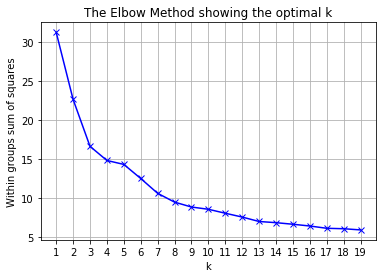

In [331]:
def elbow_met(df): # taken from the practice slides
    # k means determine k
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within groups sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.grid()
    plt.xticks(K)
    plt.show()
    
elbow_met(new_train.drop(["Survived"], axis=1))

In [332]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(new_train.drop(["Survived"], axis=1))
centroids = kmeans.cluster_centers_

distances = np.column_stack([np.sum((new_train.drop(["Survived"], axis=1) - center)**2, axis=1)**0.5 for center in centroids])
distToClusters = pd.DataFrame(data=distances)
distances_2 = np.column_stack([np.sum((validation.drop(["Survived"], axis=1) - center)**2, axis=1)**0.5 for center in centroids])
distToClusters_2 = pd.DataFrame(data=distances_2)

clusters_features,clusters_features_2 = [], []
for index, row in distToClusters.iterrows():
    clusters_features.append(row.idxmin(axis=1))
clusters_features = np.transpose(clusters_features)
for index, row in distToClusters_2.iterrows():
    clusters_features_2.append(row.idxmin(axis=1))
clusters_features_2 = np.transpose(clusters_features_2)

new_train_2 = new_train.copy()
new_train_2['Cluster'] = clusters_features
validation_2 = validation.copy()
validation_2['Cluster'] = clusters_features_2

new_train_2.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,TicketType,CabinType,Cluster
0,0,3,1,22.0,7.2500,2,2,2,1,4,0
1,1,1,0,38.0,71.2833,0,3,2,3,1,2
2,1,3,0,26.0,7.9250,2,1,1,4,4,0
3,1,1,0,35.0,53.1000,2,3,2,0,1,2
4,0,3,1,35.0,8.0500,2,2,1,0,4,0


### Attempting to improve PCA accuracy with the cluster results

In [333]:
best_score, best_n = 0, 1
for n in range(1,new_train_2.drop(["Survived"], axis=1).shape[1]):
    pca = PCA(n_components=n)
    lr = LogisticRegression(C=1.0, random_state=0, solver='lbfgs', max_iter=5000)
    train_pca = pca.fit_transform(new_train_2.drop(["Survived"], axis=1))
    validation_results = pca.transform(validation_2.drop(["Survived"], axis=1))
    lr.fit(train_pca, new_train_2.Survived)
    predicted = lr.predict(validation_results)
    actual = validation['Survived'].to_numpy()
    pca_score = accuracy_score(predicted, actual)
    if pca_score > best_score:
        best_score = pca_score
        best_n = n
print("Best PCA n_components:\t"+str(best_n))
print("PCA with linear regression score (After adding the `Cluster` feature):\t" + str(best_score))

Best PCA n_components:	9
PCA with linear regression score (After adding the `Cluster` feature):	0.8097014925373134


In [334]:
# Creating file for Kaggle
new_test = test_LE.drop(["PassengerId"], axis=1)

kmeans = KMeans(n_clusters=3, random_state=0).fit(train_LE.drop(["Survived"], axis=1))
centroids = kmeans.cluster_centers_

distances = np.column_stack([np.sum((new_test - center)**2, axis=1)**0.5 for center in centroids])
distToClusters = pd.DataFrame(data=distances)
clusters_features = []
for index, row in distToClusters.iterrows():
    clusters_features.append(row.idxmin(axis=1))
clusters_features = np.transpose(clusters_features)

distances2 = np.column_stack([np.sum((train_LE.drop(["Survived"], axis=1) - center)**2, axis=1)**0.5 for center in centroids])
distToClusters2 = pd.DataFrame(data=distances2)
clusters_features2 = []
for index, row in distToClusters2.iterrows():
    clusters_features2.append(row.idxmin(axis=1))
clusters_features2 = np.transpose(clusters_features2)

new_test_2 = new_test.copy()
new_test_2['Cluster'] = clusters_features

train_LE_2 = train_LE.copy()
train_LE_2['Cluster'] = clusters_features2


pca = PCA(n_components=best_n)
lr = LogisticRegression(C=1.0, random_state=0, solver='lbfgs', max_iter=5000)
train_pca = pca.fit_transform(train_LE_2.drop(["Survived"], axis=1))
test_results = pca.transform(new_test_2)
lr.fit(train_pca, train_LE_2.Survived)
predicted = lr.predict(test_results)

results = test.loc[:,['PassengerId']]
results["Survived"] = predicted
results.to_csv('results_pca2.csv', index=False)

# Kaggle score: 0.75598

## Classification of survivors with a Neural Network

In [20]:
def create_model(inputs=9,neurons1=1,neurons2=0,outputs=1,learn_rate=0.01,momentum=0):
    reset_random_seeds()
    model = Sequential()
    model.add(Dense(units=neurons1, input_shape=(inputs,), kernel_initializer='uniform', activation='relu'))
    # No dropout to enable reproducibility
    if neurons2 == 0: # One hidden layer
        model.add(Dense(units=outputs, kernel_initializer='uniform', activation='sigmoid'))
    else: # Two hidden layers
        model.add(Dense(units=neurons2,activation="relu",kernel_initializer="uniform"))
        model.add(Dense(units=outputs, kernel_initializer='uniform', activation='sigmoid'))
    if learn_rate == 'adam':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def binarySeries(prediction):
    predict = []
    for val in prediction:
        if val[0] >= 0.5:
            predict.append(1)
        else:
            predict.append(0)
    return np.transpose(predict)

In [21]:
reset_random_seeds()
sc = StandardScaler()
train2 = sc.fit_transform(new_train.drop(["Survived"], axis=1))
validation2 = sc.fit_transform(validation.drop(["Survived"], axis=1))

best_h1, best_h2,best_learn_rate,best_momentum, best_score, best_model = 0,0,0,0,0,None
for h1 in [2,5]:
    for h2 in [0,5,10]:
        for learn_rate in [0.001,0.01,'adam']:
            for momentum in [0,0.5]:
                model = create_model(9,h1,h2,1,learn_rate,momentum)
                print("Fitting model (h1,h2,learn_rate,momentum)=("+str(h1)+","+str(h2)+","+str(learn_rate)+","+str(momentum)+")...",end="")
                model.fit(train2,new_train.Survived, batch_size = 10, epochs = 100, verbose = 0)
                prediction = model.predict(validation2)
                score = accuracy_score(binarySeries(prediction),validation.Survived)
                print("\t"+str(round(score,3))+"\tDone!")
                if score > best_score:
                    best_score = score
                    best_h1, best_h2, best_learn_rate, best_momentum = h1, h2, learn_rate, best_momentum
                    best_model = model
                if learn_rate == 'adam':
                    break;
print("Finished!\n\nBest score:\t"+str(best_score)+"\tBest h1:\t"+str(best_h1)+"\tBest h2:\t"+str(best_h2)+"\tBest learn_rate:\t"+str(best_learn_rate)+"\tBest momentum:\t"+str(best_momentum))

Fitting model (h1,h2,learn_rate,momentum)=(2,0,0.001,0)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,0,0.001,0.5)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,0,0.01,0)...	0.806	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,0,0.01,0.5)...	0.817	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,0,adam,0)...	0.799	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,5,0.001,0)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,5,0.001,0.5)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,5,0.01,0)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,5,0.01,0.5)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,5,adam,0)...	0.813	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,10,0.001,0)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,10,0.001,0.5)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,10,0.01,0)...	0.642	Done!
Fitting model (h1,h2,learn_rate,momentum)=(2,10,0.01,0.5)...	0.642	Done

In [25]:
# Creating file for Kaggle
reset_random_seeds()
test2 = sc.fit_transform(new_test)
train_LE2 = sc.fit_transform(train_LE.drop(["Survived"], axis=1))

best_model.fit(train_LE2, train_LE.Survived, batch_size = 10, epochs = 100, verbose = 0)
prediction = best_model.predict(test2)

results = test.loc[:,['PassengerId']]
results["Survived"] = binarySeries(prediction)
results.to_csv('results_nn.csv', index=False)

# Kaggle score: 0.79904

In [24]:
columns = ['Model','Kaggle Score']
df = pd.DataFrame(columns=columns)
df = df.append({"Model":"PCA with LinearRegression","Kaggle Score":0.66985}, ignore_index=True)
df = df.append({"Model":"Decision Tree","Kaggle Score":0.74162}, ignore_index=True)
df = df.append({"Model":"Random Forest","Kaggle Score":0.76555}, ignore_index=True)
df = df.append({"Model":"KNN","Kaggle Score":0.67464}, ignore_index=True)
df = df.append({"Model":"SVM","Kaggle Score":0.75598}, ignore_index=True)
df = df.append({"Model":"XGBoost","Kaggle Score":0.77990}, ignore_index=True)
df = df.append({"Model":"PCA with LinearRegression + K-Means","Kaggle Score":0.75598}, ignore_index=True)
df = df.append({"Model":"Neural Network","Kaggle Score":0.79904}, ignore_index=True)
display(df.style.hide_index())

Model,Kaggle Score
PCA with LinearRegression,0.66985
Decision Tree,0.74162
Random Forest,0.76555
KNN,0.67464
SVM,0.75598
XGBoost,0.7799
PCA with LinearRegression + K-Means,0.75598
Neural Network,0.79904
